# Practice Lab 21- Recurrent Neural Networks
In this lab we will look at Recurrent Neural Networks. \
We will see examples of sequence to vector and sequence to sequence RNN, LSTM and GRU.\
Based on Chapter 15 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice21_RNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Add for GPU BEFORE JSON
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
####################################

        
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

2022-11-25 13:11:58.943923: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 13:12:00.326746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5
2022-11-25 13:12:00.327328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 579 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2


## Exercise 1 - Predictions of time series using different methods
Using the time series generator below, predict future samples by using:
1) Linear model (by using a Neural network)\
2) Recursive Neural network\
3) Deep Recursive Neural network\
At first predict one time sample in output (sequence to vector). \
Then predict 10 time samples in output using sequence to vector first and then sequence to sequence.


We will define a time series generator than can create many instances (time series) at once.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

Let us generate 7000 time series, each with 50 samples and an extra sample to predict (later we will predict more than one) 

In [3]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
print('batch_size, nsteps, nfeatures)=',X_train.shape, X_valid.shape, X_test.shape)

batch_size, nsteps, nfeatures)= (7000, 50, 1) (2000, 50, 1) (1000, 50, 1)


In [5]:
print(y_train.shape, y_valid.shape, y_test.shape)

(7000, 1) (2000, 1) (1000, 1)


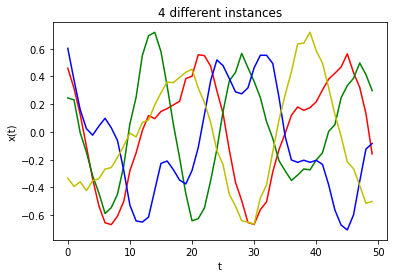

In [6]:
ts=[0,1,10,23]
plt.plot(X_train[ts[0],:,:],'r-')
plt.plot(X_train[ts[1],:,:],'g-')
plt.plot(X_train[ts[2],:,:],'b-')
plt.plot(X_train[ts[3],:,:],'y-')
plt.title('4 different instances')
plt.xlabel('t'),
plt.ylabel('x(t)');

Let us define a function to plot the input and the targets (actual and predicted).

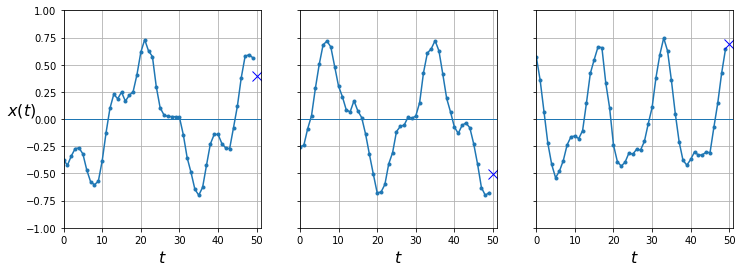

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    # the cross denotes the target. 
    # if given, the prediction is plot as a circle.
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
# let us plot 3 different instances in separate plots.

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

The simplest prediction we can do is to repeat the last sample

In [8]:
y_pred_naive=X_valid[:,-1]
print('MSE for naive prediction -->',np.mean(keras.losses.mean_squared_error(y_valid, y_pred_naive)))

MSE for naive prediction --> 0.020211367


2022-11-25 13:20:59.130367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5
2022-11-25 13:20:59.131038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 579 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2


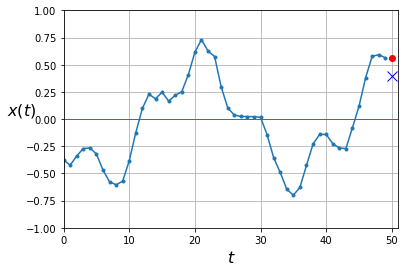

In [9]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred_naive[0, 0])

Before, getting trying RNNs, let us make a linear prediction using what we already know, that is a dense layer

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


By default, keras puts a linear activation, so the model we are building is just a linear combination (regression) with 50 dimensions.\
Question: we have 50 points and a polynomial with 50 (+1) coefficients. Would you expect it to fit perfectly?

In [11]:
print(model.layers[1].activation)

<function linear at 0x7f44460921f0>


In [12]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

Question: where does the number 219 come from?

Let us compare with the naive approach (copying the last sample)

In [13]:
print('MSE naive prediction',np.mean(keras.losses.mean_squared_error(X_valid[:,-1],y_valid)))
print('MSE error linear model',model.evaluate(X_valid, y_valid))

MSE naive prediction 0.020211367
63/63 [==============================] - 0s 1ms/step - loss: 0.0042
MSE error linear model 0.004168087616562843


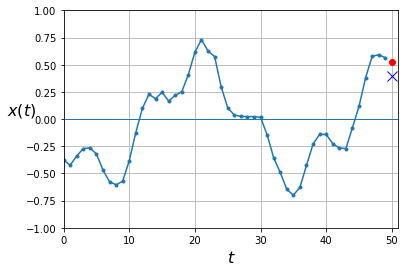

In [16]:
y_pred_DN = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred_DN[0, 0])

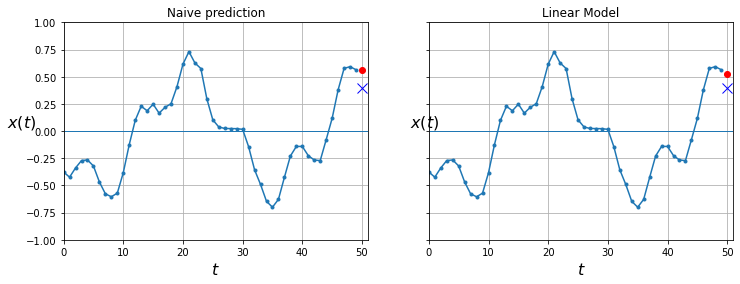

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))
col=0
plt.subplot(121),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_naive[col, 0])
plt.title('Naive prediction')
plt.subplot(122),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_DN[col, 0])
plt.title('Linear Model');

Now let us use a recursive neural network. Let start with the simplest possible: one layer and one neuron.

In [21]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Question 1: Why do we have 3 parameters? \
Question 2: Before running, can you tell if this is a better model or a worse model than the DN we ran before?

In [22]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 7s 28ms/step - loss: 0.0313 - val_loss: 0.0127
Epoch 2/10
219/219 [==============================] - 6s 28ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 3/10
219/219 [==============================] - 6s 27ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 4/10
219/219 [==============================] - 6s 27ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/10
219/219 [==============================] - 6s 27ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/10
219/219 [==============================] - 6s 27ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/10
219/219 [==============================] - 6s 27ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/10
219/219 [==============================] - 6s 28ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/10
219/219 [==============================] - 6s 27ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/10
219/219 [==============================] - 6s 27ms/step - loss: 0.0114 - val_lo

That took much longer than the DN. Let us evaluate it:

In [23]:
print('MSE naive prediction',np.mean(keras.losses.mean_squared_error(X_valid[:,-1],y_valid)))
print('MSE error RNN model',model.evaluate(X_valid, y_valid))

MSE naive prediction 0.020211367
63/63 [==============================] - 1s 8ms/step - loss: 0.0110
MSE error RNN model 0.01095960196107626


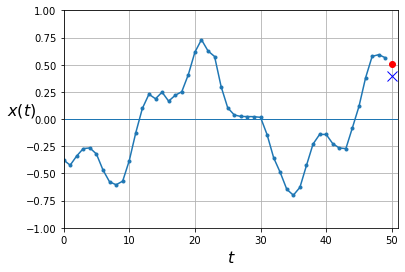

In [24]:
y_pred_RNN = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred_RNN[0, 0])

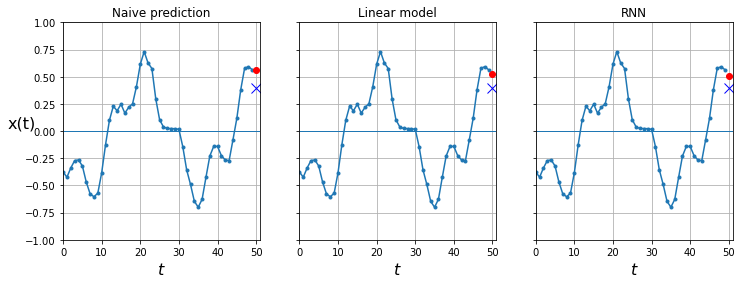

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
col=0
plt.subplot(131),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_naive[col, 0], y_label='x(t)')
plt.title('Naive prediction');
plt.subplot(132),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_DN[col, 0], y_label=None)
plt.title('Linear model')
plt.subplot(133),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_RNN[col, 0], y_label=None)
plt.title('RNN');


Disappointly, the DN (linear) prediction is better than the RNN (~10 times better). \
However, we only have 3 parameters for the RNN (one neuron) and 51 for the DN. Let us try more layers.

In [28]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


Question: why do we have 440 parameters? \
Here is a hint: 1 * 20 + 20 * 20 + 20 = 440 \
Now, try to figure what the different terms in the sum are.


In [29]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 22s 93ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/10
219/219 [==============================] - 20s 92ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 3/10
219/219 [==============================] - 20s 93ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/10
219/219 [==============================] - 20s 93ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/10
219/219 [==============================] - 20s 92ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/10
219/219 [==============================] - 20s 93ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10
219/219 [==============================] - 20s 92ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/10
219/219 [==============================] - 20s 92ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/10
219/219 [==============================] - 20s 92ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/10
219/219 [==============================] - 20s 92ms/step - loss: 0.002

In [30]:
print('MSE naive prediction',np.mean(keras.losses.mean_squared_error(X_valid[:,-1], y_valid)))
print('MSE error DRNN model',model.evaluate(X_valid, y_valid))

MSE naive prediction 0.020211367
63/63 [==============================] - 1s 19ms/step - loss: 0.0026
MSE error DRNN model 0.002649451605975628


In [31]:
y_pred_DRNN = model.predict(X_valid)

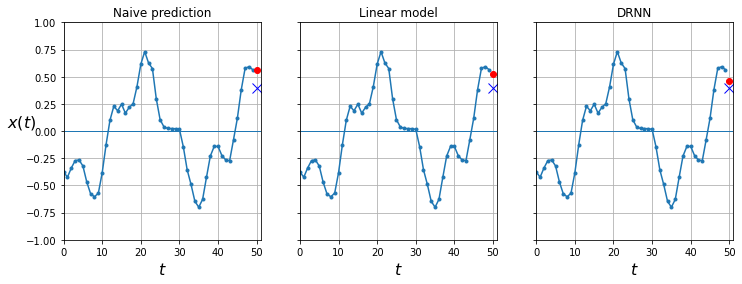

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
col=0
plt.subplot(131),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_naive[col, 0])
plt.title('Naive prediction');
plt.subplot(132),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_DN[col, 0], y_label=None)
plt.title('Linear model')
plt.subplot(133),plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred_DRNN[col, 0], y_label=None)
plt.title('DRNN');


### Predicting many points ahead

The predictions are good, but it is getting quite expensive (a lot more than the DN).\
The cost is not justified in this simple problem. \
But let us consider a more difficult task. We will now try to estimate 10 steps ahead. We could do this in two ways:
1) We predict one sample, put it in, predict the next.\
2) We predict all samples in the gap simultaneously.

For 1) we will use the same network we already trained. We just use it several times.\
First we need to predict a time series for testing (because we need more steps ahead to test).

In [36]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [38]:
print(X_new.shape,Y_new.shape,X.shape,Y_pred.shape)

(1, 50, 1) (1, 10, 1) (1, 60, 1) (1, 10, 1)


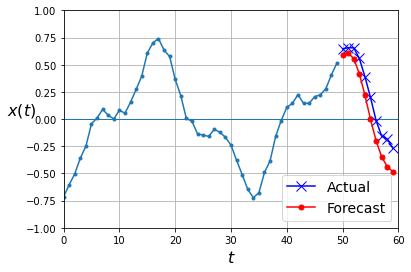

In [39]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Actual", markersize=10)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Forecast", markersize=5)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


Now we will do the prediction simultaneously. We need to generate the training dataset again with 10 steps ahead.

In [40]:
#before
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(7000, 50, 1) (2000, 50, 1) (1000, 50, 1)
(7000, 1) (2000, 1) (1000, 1)


In [43]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [44]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

(7000, 50, 1) (2000, 50, 1) (1000, 50, 1)
(7000, 10) (2000, 10) (1000, 10)


In [45]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

Question: how can you know which model was used to generate y_pred_one? 

In [46]:
print(X_valid.shape,Y_valid.shape,Y_pred.shape)

(2000, 50, 1) (2000, 10) (2000, 10)


In [47]:
Y_naive_pred = Y_valid[:, -1:]
Y_pred_RNN = Y_pred
print('MSE for 10 step predictions naive approach',np.mean(keras.metrics.mean_squared_error(Y_valid, Y_valid[:,-1:])))
print('MSE for 10 step predictions of 10 values',np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred_RNN)))

MSE for 10 step predictions naive approach 0.22278848
MSE for 10 step predictions of 10 values 0.030177947


In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


The 10 steps RNN is much better than the Naive approach. Let us compare with the DN that worked well before. \
We need to redefine it (why?)

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
219/219 [==============================] - 1s 2ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0222

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


How does the DN with one step prediction compares with 10 step prediction in terms of complexity?

In [51]:
Y_pred_DN10 = model.predict(X_valid)

In [52]:
print(Y_pred.shape)
print(Y_pred_DN10.shape)

(2000, 10)
(2000, 10)


In [53]:
print('MSE for 10 step predictions Linear Model',np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred_DN10)))
print('MSE for 10 step predictions of 10 values',np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred_RNN)))

MSE for 10 step predictions Linear Model 0.022187142
MSE for 10 step predictions of 10 values 0.030177947


The linear model is better and quicker!

(2000, 50, 1) (2000, 10) (2000, 10)
50 10
(2000, 50, 1) (2000, 10) (2000, 10)
50 10


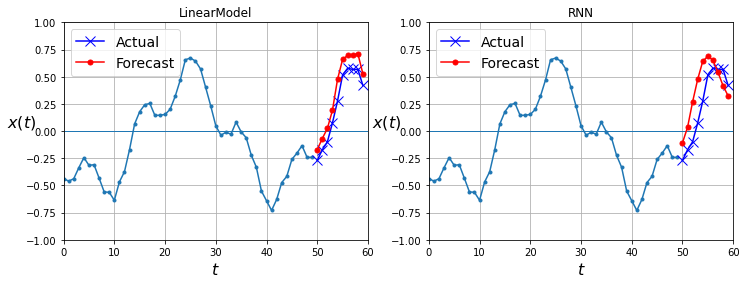

In [54]:
def plot_multiple_forecasts(X, Y, Y_pred):
    print(X.shape, Y.shape, Y_pred.shape)
    n_steps = X.shape[1]    
    ahead = Y.shape[1]
    print(n_steps, ahead)
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :], "bx-", label="Actual", markersize=10)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :], "ro-", label="Forecast", markersize=5)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

    
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))    
plt.subplot(121),plot_multiple_forecasts(X_valid[:,:,:], Y_valid[:,:], Y_pred_DN10[:,:]),plt.title("LinearModel")
plt.subplot(122),plot_multiple_forecasts(X_valid[:,:,:], Y_valid[:,:], Y_pred_RNN[:,:]),plt.title("RNN");

plt.show()

Now let us do the DRNN again but all 10 steps at once, we need to put nsteps neurons in the last layer (like in DN).

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
219/219 [==============================] - 15s 61ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/10
219/219 [==============================] - 13s 60ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/10
219/219 [==============================] - 14s 62ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/10
219/219 [==============================] - 13s 60ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/10
219/219 [==============================] - 13s 61ms/step - loss: 0.011

In [57]:
np.random.seed(43) # again we use a different number for random seed to prevent repeating the training series.
# Generate one time serie to predict with 50 steps and 10 steps ahead.
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

(1, 50, 1) (1, 10, 1) (1, 10, 1)
50 10


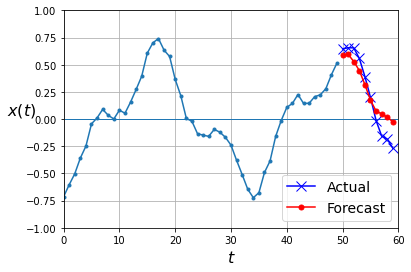

In [58]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [59]:
print('MSE for multistep DNN',model.evaluate(X_valid,Y_valid))

63/63 [==============================] - 1s 13ms/step - loss: 0.0100
MSE for multistep DNN 0.009980153292417526


In [60]:
Y_pred_RNN10 = model.predict(X_valid)

In [61]:
print('MSE for 1 step predictions of 10 values Linear Model',np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred_DN10)))
print('RNN MSE for 10 step predictions of 10 values',np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred_RNN)))
print('RNN MSE for 1  step predictions of 10 values',np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred_RNN10)))

MSE for 1 step predictions of 10 values Linear Model 0.022187142
RNN MSE for 10 step predictions of 10 values 0.030177947
RNN MSE for 1  step predictions of 10 values 0.009980152


(2000, 50, 1) (2000, 10) (2000, 10)
50 10
(2000, 50, 1) (2000, 10) (2000, 10)
50 10
(2000, 50, 1) (2000, 10) (2000, 10)
50 10


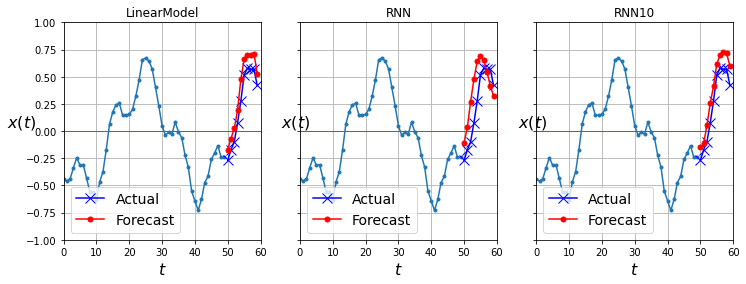

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))    
plt.subplot(131),plot_multiple_forecasts(X_valid[:,:,:], Y_valid[:,:], Y_pred_DN10[:,:]),plt.title("LinearModel")
plt.subplot(132),plot_multiple_forecasts(X_valid[:,:,:], Y_valid[:,:], Y_pred_RNN[:,:]),plt.title("RNN");
plt.subplot(133),plot_multiple_forecasts(X_valid[:,:,:], Y_valid[:,:], Y_pred_RNN10[:,:]),plt.title("RNN10");

plt.show()

There is one more way to do multistep predictions. We can do sequence to sequence as follows.\
We can evaluate the 10 next steps for each step (instead of the last 10 steps only).\
These values can be used to estimate gradients during training but not for predictions since it is causal model.\
Causal means that the model can see the past not the future (like humans, not counting Nostradamus).

In [63]:
# so far we had
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

(7000, 50, 1) (2000, 50, 1) (1000, 50, 1)
(7000, 10) (2000, 10) (1000, 10)


When generating the time series we need to allocate the targets in groups of 10 since the training now will be using 10 samples for each time steps. 

In [64]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [65]:
# now we have
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

(7000, 50, 1) (2000, 50, 1) (1000, 50, 1)
(7000, 50, 10) (2000, 50, 10) (1000, 50, 10)


If we look at the shape of the target vector, we see it has an extra dimension of 10 for each of the time steps.

In [66]:
print('y train size is (nbatches, nsteps, nsteps_ahead) =',Y_train.shape)

y train size is (nbatches, nsteps, nsteps_ahead) = (7000, 50, 10)


In [67]:
print('X train is similar as before (nbatches, nsteps, 1) =',X_train.shape)

X train is similar as before (nbatches, nsteps, 1) = (7000, 50, 1)


To predict 10 samples at the end of the series we just used the dense network with 10 neurons.\
Now, however, we need to predict 10 samples for each step. Keras has the TimeDistributed layer to help to do this.\
It needs to pass the Dense layer with 10 neurons (the same as before) but TimeDistributed will used it at each step.\
In addition, we need to use a custom metric that only calculates the error at the end (even when gradients are used for all time steps, we want the error to be measured at the end only).


In [68]:
np.random.seed(42)
tf.random.set_seed(42)
#Time distributed will call the dense layer at each step.
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
#Customized metric to measure error only with the last 10 samples of each batch.
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
219/219 [==============================] - 15s 63ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0353 - val_last_time_step_mse: 0.0245
Epoch 3/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0323 - last_time_step_mse: 0.0210 - val_loss: 0.0298 - val_last_time_step_mse: 0.0183
Epoch 4/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0296 - last_time_step_mse: 0.0184 - val_loss: 0.0270 - val_last_time_step_mse: 0.0150
Epoch 5/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0273 - last_time_step_mse: 0.0155 - val_loss: 0.0263 - val_last_time_step_mse: 0.0142
Epoch 6/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0251 - last_time_step_mse: 0.0124 - val_loss: 0.0225 - val_last_time_step_mse: 0.0092
Epoch 7/10
219/2

Once again we create a testing time series (one batch, 50 steps + 10 steps ahead).\
We call X the series with the 50 steps only (without the 10), y is the series with the 10 steps ahead.\
The syntaxis in the prediction is a bit strange but it just does a reshaping to take the last 10 steps.\
Remember the TimeDistribute will predict 10 steps for each of the 50 steps, therefore making a matrix (50x10).\
We just want the 10 predictions for the last step.


In [70]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred_DRNN = model.predict(X_new)[:, -1][..., np.newaxis]
print(Y_new.shape,Y_pred_DRNN.shape)

(1, 10, 1) (1, 10, 1)


To understand the effect of the filter [:,-1][...,np.newaxis] after predict, let us output without it:

In [71]:
Y_pred0 = model.predict(X_new)
print(Y_pred0.shape)

(1, 50, 10)


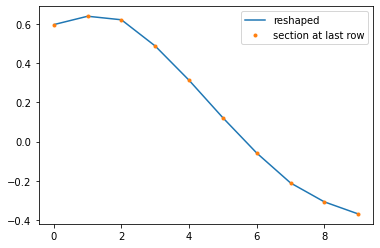

In [72]:
plt.plot(Y_pred_DRNN[0,:,0],label='reshaped')
plt.plot(Y_pred0[0, -1, :],'.',label='section at last row')
plt.legend();

Text(0.5, 1.0, 'predictions in step 40')

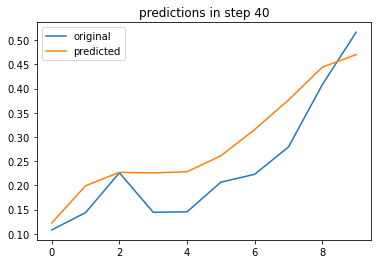

In [73]:
# we don't have values 50-60 in X, so let us plot 40:50
plt.plot(X_new[0,40:50,0],label='original')
plt.plot(Y_pred0[0,39,:],label='predicted')
plt.legend();plt.title('predictions in step 40')

(1, 50, 1) (1, 10, 1) (1, 10, 1)
50 10


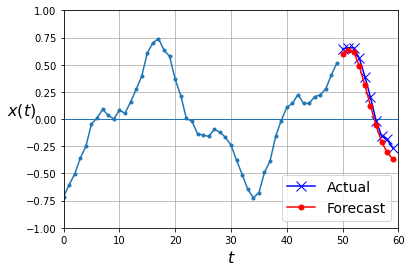

In [74]:
plot_multiple_forecasts(X_new, Y_new, Y_pred_DRNN)
plt.show()

In [75]:
MSE_DRNN=model.evaluate(X_valid, Y_valid)
print(MSE_DRNN)

63/63 [==============================] - 1s 14ms/step - loss: 0.0214 - last_time_step_mse: 0.0088
[0.021427229046821594, 0.008837937377393246]


## Exercise 2: Long Short-Term Memory and Gate Recurrent Unit
Let us now use the LSTM, the GRU and compare with the DRNN.\
Everything is similar, except we use the LSTM layer instead of SimpleRNN.\
Also we need the TimeDistributed Layer to predict 10 samples at each time step.

In [76]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10


2022-11-25 17:17:13.756391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


219/219 [==============================] - 6s 12ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/10
219/219 [==================

Notice the time at each iteration was much smaller than before. LSTM can remember more with less effort.

In [77]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred_LSTM = model.predict(X_new)[:, -1][..., np.newaxis]
print(Y_new.shape,Y_pred.shape)

(1, 10, 1) (1, 10, 1)


(1, 50, 1) (1, 10, 1) (1, 10, 1)
50 10


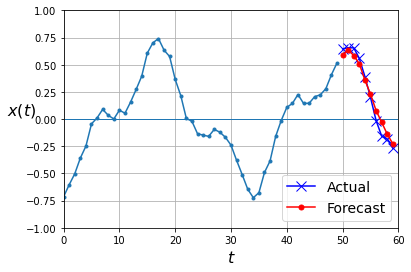

In [78]:
plot_multiple_forecasts(X_new, Y_new, Y_pred_LSTM)
plt.show()

In [79]:
MSE_LSTM=model.evaluate(X_valid, Y_valid)
print(MSE_LSTM)

63/63 [==============================] - 0s 4ms/step - loss: 0.0268 - last_time_step_mse: 0.0101
[0.0268427561968565, 0.010114365257322788]


Now the GRU

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10
219/219 [==============================] - 4s 11ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/10
219/219 [=======

This was half the time than the LSTM and much faster than DRNN

In [81]:
Y_pred_GRU = model.predict(X_new)[:, -1][..., np.newaxis]
print(Y_new.shape,Y_pred_GRU.shape)

(1, 10, 1) (1, 10, 1)


(1, 50, 1) (1, 10, 1) (1, 10, 1)
50 10
(1, 50, 1) (1, 10, 1) (1, 10, 1)
50 10
(1, 50, 1) (1, 10, 1) (1, 10, 1)
50 10


(<AxesSubplot:xlabel='$t$', ylabel='$x(t)$'>, None)

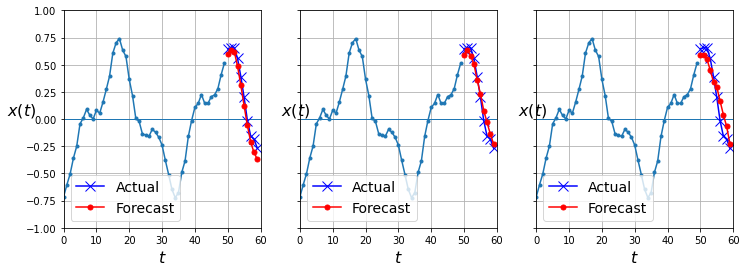

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
plt.subplot(131),plot_multiple_forecasts(X_new, Y_new, Y_pred_DRNN)
plt.subplot(132),plot_multiple_forecasts(X_new, Y_new, Y_pred_LSTM)
plt.subplot(133),plot_multiple_forecasts(X_new, Y_new, Y_pred_GRU)

In [83]:
MSE_GRU=model.evaluate(X_valid, Y_valid)
print(MSE_GRU)

63/63 [==============================] - 0s 4ms/step - loss: 0.0264 - last_time_step_mse: 0.0121
[0.026423657312989235, 0.012129548005759716]


In [84]:
print(np.round(MSE_DRNN,4), np.round(MSE_LSTM,4), np.round(MSE_GRU,4))

[0.0214 0.0088] [0.0268 0.0101] [0.0264 0.0121]
